In [7]:
! pip install -U tushare
! pip install -U pandas

Requirement already up-to-date: tushare in d:\code\stock-trade-system\.env\lib\site-packages (1.2.62)
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in d:\code\stock-trade-system\.env\lib\site-packages (1.1.3)
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [63]:
import tushare as ts
import pandas as pd
import numpy as np

In [94]:
df_tick = ts.get_tick_data('002372', date='2020-01-23', src='tt')
print(df_tick[2000:2010])

          time  price  change  volume  amount type
2000  13:37:16  12.39   -0.01     126  156114   卖盘
2001  13:37:19  12.38   -0.01       1    1238   卖盘
2002  13:37:25  12.38    0.00      39   48322   卖盘
2003  13:37:28  12.39    0.01      25   30953   买盘
2004  13:37:37  12.38   -0.01       2    2476  中性盘
2005  13:37:40  12.36   -0.02      14   17345   卖盘
2006  13:37:43  12.40    0.04       1    1240   买盘
2007  13:37:46  12.40    0.00       1    1240   买盘
2008  13:37:49  12.40    0.00      63   77978   买盘
2009  13:37:58  12.39   -0.01       1    1239   买盘


In [95]:
df_tick.index = pd.to_datetime(df_tick.time)
df_tick.drop(axis=1, columns='time', inplace=True)
print(df_tick[2000:2010])

                     price  change  volume  amount type
time                                                   
2020-10-27 13:37:16  12.39   -0.01     126  156114   卖盘
2020-10-27 13:37:19  12.38   -0.01       1    1238   卖盘
2020-10-27 13:37:25  12.38    0.00      39   48322   卖盘
2020-10-27 13:37:28  12.39    0.01      25   30953   买盘
2020-10-27 13:37:37  12.38   -0.01       2    2476  中性盘
2020-10-27 13:37:40  12.36   -0.02      14   17345   卖盘
2020-10-27 13:37:43  12.40    0.04       1    1240   买盘
2020-10-27 13:37:46  12.40    0.00       1    1240   买盘
2020-10-27 13:37:49  12.40    0.00      63   77978   买盘
2020-10-27 13:37:58  12.39   -0.01       1    1239   买盘


In [96]:
# 重新获取历史信息
import datetime
# df_tick=ts.get_hist_data('sh',start='2008-01-01',end=datetime.datetime.now().strftime('%Y-%m-%d'))
# print(df_tick)
df_min_ohlc = df_tick.price.resample("1min", closed='left', label='left').ohlc()
print(df_min_ohlc)

                      open   high    low  close
time                                           
2020-10-27 09:25:00  12.78  12.78  12.78  12.78
2020-10-27 09:26:00    NaN    NaN    NaN    NaN
2020-10-27 09:27:00    NaN    NaN    NaN    NaN
2020-10-27 09:28:00    NaN    NaN    NaN    NaN
2020-10-27 09:29:00    NaN    NaN    NaN    NaN
...                    ...    ...    ...    ...
2020-10-27 14:56:00  12.39  12.40  12.38  12.39
2020-10-27 14:57:00    NaN    NaN    NaN    NaN
2020-10-27 14:58:00    NaN    NaN    NaN    NaN
2020-10-27 14:59:00    NaN    NaN    NaN    NaN
2020-10-27 15:00:00  12.40  12.40  12.40  12.40

[336 rows x 4 columns]


In [86]:
# 清洗数据，非交易时间段的NaN数据
df_min_ohlc = df_min_ohlc.dropna(axis=0, how='all')
print(df_min_ohlc.head())

                      open   high    low  close
time                                           
2020-10-27 09:25:00  12.78  12.78  12.78  12.78
2020-10-27 09:30:00  12.76  12.76  12.61  12.66
2020-10-27 09:31:00  12.66  12.66  12.64  12.64
2020-10-27 09:32:00  12.64  12.64  12.59  12.59
2020-10-27 09:33:00  12.63  12.68  12.61  12.67


In [40]:
# 数据可视化 画图
! pip install -U matplotlib
! pip install -U mpl-finance
! pip install -U mplfinance


Requirement already up-to-date: matplotlib in d:\code\stock-trade-system\.env\lib\site-packages (3.3.2)
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Requirement already up-to-date: mpl-finance in d:\code\stock-trade-system\.env\lib\site-packages (0.10.1)
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.



In [87]:
series_data ={'Open': df_min_ohlc.open, 'Close': df_min_ohlc.close, 'High': df_min_ohlc.high, 'Low': df_min_ohlc.low}
df_stockload = pd.DataFrame(series_data)

['binance', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo']


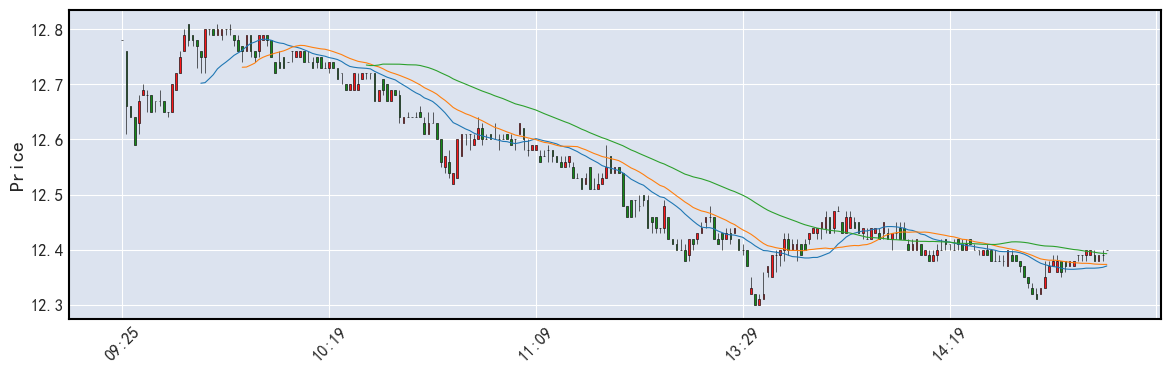

In [88]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mplfinance as mpf
print(mpf.available_styles())

# 解决中文乱码
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# 创建fig对象
fig = plt.figure(figsize=(12,6), dpi=100, facecolor='white')

# 指定子图放置的网格几何位置
gs = gridspec.GridSpec(3, 1, left=0.08, bottom=0.15, right=0.99, top=0.96, wspace=None, hspace=0, height_ratios=[3.5, 1, 1])

# 添加子图
graph_KAV = fig.add_subplot(gs[0, :])
# graph_MACD = fig.add_subplot(gs[1, :])
# graph_KDJ = fig.add_subplot(gs[2, :])


# 绘制K线图
# graph_KAV.legend(loc='best')
# graph_KAV.set_title(u"002372 伟星新材-分钟K线")
# graph_KAV.set_ylabel(u"价格")
# graph_KAV.set_xlim(0, len(df_stockload.index))  # 设置一下x轴的范围

# 设置style，上涨红色，下跌绿色
mc = mpf.make_marketcolors(up='r',down='g')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df_stockload, ax=graph_KAV,type="candle", mav=(20,30,60), figratio=(11,8),figscale=0.85, style=s)  # mav表示移动平均线
# mpf.candlestick2_ochl(graph_KAV, df_stockload.Open, df_stockload.Close, df_stockload.High, df_stockload.Low,
#                           width=0.5,
#                           colorup='r', colordown='g')  # 绘制K线走势


# 绘制移动平均线图
# df_stockload["Ma20"] = df_stockload.Close.rolling(window=20).mean()
# df_stockload["Ma30"] = df_stockload.Close.rolling(window=30).mean()
# df_stockload["Ma60"] = df_stockload.Close.rolling(window=60).mean()

# graph_KAV.plot(np.arange(0, len(df_stockload.index)), df_stockload['Ma20'], 'black', label='M20', lw=1.0)

plt.show()